## PARIS SUBSIDIES: EXPLORATORY DATA ANALYSIS

### LIBRAIRIES IMPORT

In [101]:
# Data
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium

# Wordcloud
from wordcloud import WordCloud

%matplotlib inline


### DATA IMPORT

In [18]:
data = pd.read_feather('../00_DataFiles/03_Joined/ParisSubsidies_Joined.feather')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79961 entries, 0 to 79960
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   numero_dossier                          79961 non-null  object        
 1   annee_budgetaire                        79961 non-null  int64         
 2   siret                                   79961 non-null  object        
 3   objet_dossier                           79961 non-null  object        
 4   montant_vote                            79961 non-null  int64         
 5   direction                               79961 non-null  object        
 6   nature_subvention                       79961 non-null  object        
 7   secteurs_activites                      79961 non-null  object        
 8   categorie_entreprise                    79961 non-null  category      
 9   tranche_effectifs_unite_legale          79961 non-

In [19]:
data.isna().sum()

numero_dossier                            0
annee_budgetaire                          0
siret                                     0
objet_dossier                             0
montant_vote                              0
direction                                 0
nature_subvention                         0
secteurs_activites                        0
categorie_entreprise                      0
tranche_effectifs_unite_legale            0
tranche_effectifs_unite_legale_triable    0
siret_siege_unite_legale                  0
etablissement_siege                       0
code_postal_etablissement                 0
caractere_employeur_unite_legale          0
date_creation_unite_legale                0
date_creation_etablissement               0
denomination_unite_legale                 0
adresse_etablissement_complete            0
latitude                                  0
longitude                                 0
montant_vote_scale                        0
montant_vote_cat                

In [20]:
# Datatypes
data.tranche_effectifs_unite_legale_triable = data.tranche_effectifs_unite_legale_triable.astype(int)
data.etablissement_siege = data.etablissement_siege.astype(int)
data.caractere_employeur_unite_legale = data.caractere_employeur_unite_legale.astype(int)

### GENERAL STATISTICS

#### Coverage

In [21]:
nb_years = data.annee_budgetaire.nunique()
print(f'Data covers the period: {data.annee_budgetaire.min()}-{data.annee_budgetaire.max()}')

Data covers the period: 2013-2021


#### Records

In [22]:
# Number of records
print(f'Number of records: {data.shape[0]:,.0f} i.e. {data.shape[0]/nb_years:,.0f} by year in average')

Number of records: 79,961 i.e. 8,885 by year in average


#### Subsidies

In [23]:
print(f'Total subsidies: {data.montant_vote.sum():,.0f} EUR, i.e. {data.montant_vote.sum()/nb_years:,.0f} EUR by year in average')

Total subsidies: 2,427,245,280 EUR, i.e. 269,693,920 EUR by year in average


In [24]:
print(f'Minimal subsidy (excluding rejected requests): {data.loc[data.subsidy_granted_bool == True].montant_vote.min():,.0f} EUR')
print(f'Maximal subsidy (excluding rejected requests): {data.loc[data.subsidy_granted_bool == True].montant_vote.max():,.0f} EUR')

Minimal subsidy (excluding rejected requests): 1 EUR
Maximal subsidy (excluding rejected requests): 17,446,000 EUR


#### Non-profit organisations

In [25]:
print(f'Number of non-profit organisations: {data.siret_siege_unite_legale.nunique():,.0f}')
print(f'Number of branches: {data.siret.nunique():,.0f}')

Number of non-profit organisations: 10,160
Number of branches: 11,101


#### Reject rate

In [26]:
# Reject rate
avg_reject_rate = len(data.loc[data.subsidy_granted_bool == False]) / len(data)
print(f'In average, Paris City Council rejects {avg_reject_rate:.0%} of the subsidy requests it receives')

In average, Paris City Council rejects 39% of the subsidy requests it receives


### DETAILED STATISTICS (all records)

#### Subsidies & Reject rates

In [27]:
# BY YEAR: SUBSIDIES & MEAN

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Dataframes
gb = data.groupby('annee_budgetaire').agg(total_subsidies = ('montant_vote', 'sum'), mean_subsidy = ('montant_vote', 'mean'))

# Add traces
fig.add_trace(
    go.Bar(x=gb.index, y=gb.total_subsidies, name='Total subsidies'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=gb.index, y=gb.mean_subsidy, name='Mean subsidy'),
    secondary_y=True,
)

# Layout
fig.update_layout(
    title_text='<b>Total subsidies & Mean subsidy by Budget year</b>',
    showlegend = False,
    hovermode='x unified',
)

# Set x-axis title
fig.update_xaxes(title_text='<b>Budget year</b>')

# Set y-axes titles
fig.update_yaxes(title_text='<b>Total</b> subsidies', color = '#636EFA', secondary_y=False)
fig.update_yaxes(title_text='<b>Mean</b> subsidy', color='#EF553B', showgrid = False, tickformat = ',.0f', secondary_y=True)

fig.show()

In [28]:
# BY YEAR: NUMBER OF REQUESTS & REJECT RATE

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Dataframes
gb = data.groupby('annee_budgetaire').agg(nb_dossiers = ('numero_dossier', 'count'))
ct = pd.crosstab(data.annee_budgetaire, data.subsidy_granted_bool, normalize='index').reindex(gb.index)

# Add traces
fig.add_trace(
    go.Bar(x=gb.index, y=gb.nb_dossiers, name='Number of requests'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=ct.index, y=ct[False], name='Reject rate'),
    secondary_y=True,
)

# Layout
fig.update_layout(
    title_text='<b>Number of requests & Reject rate by Budget year</b>',
    showlegend = False,
    hovermode='x unified',
)

# Set x-axis title
fig.update_xaxes(title_text='<b>Budget year</b>')

# Set y-axes titles
fig.update_yaxes(title_text='<b>Number</b> of requests', color = '#636EFA', secondary_y=False)
fig.update_yaxes(title_text='<b>Reject</b> rate', color='#EF553B', showgrid = False, tickformat = '.1%', secondary_y=True)

fig.show()

In [29]:
# BY DIRECTION: SUBSIDIES & MEAN

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Dataframes
gb = data.groupby('direction').agg(total_subsidies = ('montant_vote', 'sum'), mean_subsidy = ('montant_vote', 'mean')).sort_values(by='total_subsidies', ascending = False)
gb['avg_yearly_subsidies'] = gb.total_subsidies / nb_years

# Add traces
fig.add_trace(
    go.Bar(x=gb.index, y=gb.avg_yearly_subsidies, name='Yearly subsidies'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=gb.index, y=gb.mean_subsidy, name='Mean subsidy', mode = 'markers', marker = dict(symbol = 'triangle-up', size = 10)),
    secondary_y=True,
)

# Layout
fig.update_layout(
    title_text='<b>Yearly subsidies & Mean subsidy by Direction</b>',
    showlegend = False,
    hovermode='x unified',
)

# Set x-axis title
fig.update_xaxes(title_text='<b>Direction</b>')

# Set y-axes titles
fig.update_yaxes(title_text='<b>Yearly</b> subsidies', color = '#636EFA', range = [0,80000000], secondary_y=False)
fig.update_yaxes(title_text='<b>Mean</b> subsidy', color='#EF553B', showgrid = False, range = [0,200000], secondary_y=True)

fig.show()

In [30]:
# By direction

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Dataframes
gb = data.groupby('direction').agg(total_subsidies = ('montant_vote', 'sum')).sort_values(by='total_subsidies', ascending = False)
gb['avg_yearly_subsidies'] = gb.total_subsidies / nb_years
ct = pd.crosstab(data.direction, data.subsidy_granted_bool, normalize='index').reindex(gb.index)

# Add traces
fig.add_trace(
    go.Bar(x=gb.index, y=gb.avg_yearly_subsidies, name='Yearly subsidies (average)'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=ct.index, y=ct[False], name='Reject rate'),
    secondary_y=True,
)

# Layout
fig.update_layout(
    title_text='<b>Yearly subsidies by Direction</b>',
    showlegend = False,
    hovermode='x unified',
)

# Set x-axis title
fig.update_xaxes(title_text='<b>Direction</b>')

# Set y-axes titles
fig.update_yaxes(title_text='<b>Yearly</b> subsidies', color = '#636EFA', secondary_y=False)
fig.update_yaxes(title_text='<b>Reject</b> rate', color='#EF553B', showgrid = False, tickformat = '.1%', secondary_y=True)

fig.show()

In [31]:
# By geography

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Dataframes
gb = data.groupby('geo_cat').agg(total_subsidies = ('montant_vote', 'sum')).sort_values(by='total_subsidies', ascending = False)
gb['avg_yearly_subsidies'] = gb.total_subsidies / nb_years
ct = pd.crosstab(data.geo_cat, data.subsidy_granted_bool, normalize='index').reindex(gb.index)

# Add traces
fig.add_trace(
    go.Bar(x=gb.index, y=gb.avg_yearly_subsidies, name='Yearly subsidies (average)'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=ct.index, y=ct[False], name='Reject rate'),
    secondary_y=True,
)

# Layout
fig.update_layout(
    title_text='<b>Yearly subsidies by Geography</b>',
    showlegend = False,
    hovermode='x unified',
)

# Set x-axis title
fig.update_xaxes(title_text='<b>Geography</b>')

# Set y-axes titles
fig.update_yaxes(title_text='<b>Yearly</b> subsidies', color = '#636EFA', secondary_y=False)
fig.update_yaxes(title_text='<b>Reject</b> rate', color='#EF553B', showgrid = False, tickformat = '.1%', secondary_y=True)

fig.show()

In [32]:
gb = data.groupby('geo_cat').agg(total_subsidies = ('montant_vote', 'sum')).sort_values(by='total_subsidies', ascending = False)
fig = px.pie(gb, values='total_subsidies', names=gb.index, title='Share of granted subsidies by geography')
fig.show()

In [33]:
# BY NATURE: NUMBER OF REQUESTS & REJECT RATE

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Dataframes
gb = data.groupby('nature_subvention').agg(nb_dossiers = ('numero_dossier', 'count'))
ct = pd.crosstab(data.nature_subvention, data.subsidy_granted_bool, normalize='index').reindex(gb.index)

# Add traces
fig.add_trace(
    go.Bar(x=gb.index, y=gb.nb_dossiers, name='Number of requests'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=ct.index, y=ct[False], name='Reject rate'),
    secondary_y=True,
)

# Layout
fig.update_layout(
    title_text='<b>Number of requests & Reject rate by Nature</b>',
    showlegend = False,
    hovermode='x unified',
)

# Set x-axis title
fig.update_xaxes(title_text='<b>Nature</b>')

# Set y-axes titles
fig.update_yaxes(title_text='<b>Number</b> of requests', color = '#636EFA', secondary_y=False)
fig.update_yaxes(title_text='<b>Reject</b> rate', color='#EF553B', showgrid = False, tickformat = '.1%', secondary_y=True)

fig.show()

### Distribution

In [34]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Dataframes
gb = data.groupby('montant_vote_cat').agg(nb_dossiers = ('numero_dossier', 'count'), total_subsidies = ('montant_vote', 'sum'))
gb['avg_yearly_subsidies'] = gb.total_subsidies / nb_years
gb['avg_nb_dossiers'] = gb.nb_dossiers / nb_years

# Add traces
fig.add_trace(
    go.Bar(x=gb.index, y=gb.avg_yearly_subsidies, name='Yearly subsidies'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=gb.index, y=gb.avg_nb_dossiers, name='Number of requests'),
    secondary_y=True,
)

# Layout
fig.update_layout(
    title_text='<b>Yearly subsidies and Number of Requests by Subsidy size</b>',
    showlegend = False,
    hovermode='x unified',
)

# Set x-axis title
fig.update_xaxes(title_text='<b>Subsidy</b> size')

# Set y-axes titles
fig.update_yaxes(title_text='<b>Yearly</b> subsidies', color = '#636EFA', secondary_y=False)
fig.update_yaxes(title_text='<b>Number</b> of requests', color='#EF553B', showgrid = False, tickformat = '.0f', secondary_y=True)

fig.show()

### DETAILED ANALYSIS (TOP 5 Directions for 1-100k subsidy size)

#### Subsets definition

In [35]:
data_subset = data.loc[(data.montant_vote_scale > 2) & (data.montant_vote_scale < 5)]

In [36]:
top5_directions_subset = data_subset.groupby('direction').count().sort_values(by='numero_dossier', ascending = False).index.to_list()[0:5]
data_subset_top5_directions = data_subset.loc[data_subset.direction.isin(top5_directions_subset)]

#### Maps

In [37]:
df_map = data_subset_top5_directions.groupby(['siret', 'denomination_unite_legale', 'adresse_etablissement_complete', 'direction']).agg(lat = ('latitude','mean'), lon = ('longitude', 'mean'), total_subsidies = ('montant_vote', 'sum'))
df_map = df_map.reset_index(level=[1,2,3])
df_map.drop(df_map.loc[df_map.total_subsidies == 0].index, axis = 0, inplace = True)

In [38]:
fig = px.scatter_mapbox(df_map, lat='lat', lon='lon', hover_name='denomination_unite_legale', hover_data=['adresse_etablissement_complete', 'total_subsidies'], zoom=3, height=300, color = 'direction', size = 'total_subsidies')
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### FUN FACTS

In [39]:
# subsidies requests that got less than 10 EUR
data.loc[(data.montant_vote>0) & (data.montant_vote<=100)]

,numero_dossier,annee_budgetaire,siret,objet_dossier,montant_vote,direction,nature_subvention,secteurs_activites,categorie_entreprise,tranche_effectifs_unite_legale,...,adresse_etablissement_complete,latitude,longitude,montant_vote_scale,montant_vote_cat,subsidy_granted_bool,subsidy_granted,dpt_code,geo_cat,arrondissement
24129,2018_06426,2018,82971281900012,Financement pour l'animation proposée dans le ...,90,DEVE,Projet,"[Culture & Arts, Education & formation, Vie et...",PME,Etablissement non employeur,...,"40 RUE LAURISTON, 75116 PARIS 16",2.291084,48.870427,1.0,<1k EUR,True,yes,75,Paris,16
41491,2019_05587,2019,75187220100015,Appel à Projet Printemps des Cimetières,90,DEVE,Projet,"[Education & formation, Environnement & écolog...",Non productif,Etablissement non employeur,...,"72 RUE DE SAUSSURE, 75017 PARIS 17",48.886218,2.314163,1.0,<1k EUR,True,yes,75,Paris,17
42721,2019_07125,2019,82971281900012,Financement pour l'animation proposée dans le ...,90,DEVE,Projet,"[Culture & Arts, Education & formation, Vie et...",PME,Etablissement non employeur,...,"40 RUE LAURISTON, 75116 PARIS 16",2.291084,48.870427,1.0,<1k EUR,True,yes,75,Paris,16
44499,2019_04762,2019,48102744900026,LES P'TITS MATINS,1,DFPE,Fonctionnement,"[Social, Vie et animation locale]",PME,10 à 19 salariés,...,"5 RUE DE LA BOULE ROUGE, 75009 PARIS 9",48.873436,2.344671,0.0,<1k EUR,True,yes,75,Paris,09
59388,2020_04669,2020,75187220100015,APPEL A PROJET PRINTEMPS DES CIMETIERES,100,DEVE,Projet,"[Education & formation, Environnement & écolog...",Non productif,Etablissement non employeur,...,"72 RUE DE SAUSSURE, 75017 PARIS 17",48.886218,2.314163,2.0,<1k EUR,True,yes,75,Paris,17
64194,2020_11006,2020,48753093300026,subvention compensatrice Covid-19,88,DJS,Fonctionnement,[Sport],PME,1 ou 2 salariés,...,"93 QUAI DE VALMY, 75010 PARIS 10",48.873736,2.362974,1.0,<1k EUR,True,yes,75,Paris,10
65838,2020_11082,2020,44785716000025,Subvention exceptionnelle sportive COVID 19,100,DJS,Projet,[Sport],Non productif,Etablissement non employeur,...,"66 RUE SAINT LAZARE, 75009 PARIS 9",48.876834,2.332535,2.0,<1k EUR,True,yes,75,Paris,09


In [40]:
data.loc[50481]

numero_dossier                                                                   2013_05524
annee_budgetaire                                                                       2013
siret                                                                        31669616000019
objet_dossier                                                        Subvention d'équilibre
montant_vote                                                                       17446000
direction                                                                               DAC
nature_subvention                                                            Fonctionnement
secteurs_activites                        [Culture & Arts, Education & formation, Idée &...
categorie_entreprise                                                                    PME
tranche_effectifs_unite_legale                                           100 à 199 salariés
tranche_effectifs_unite_legale_triable                                          

In [41]:
# Top 5 most funded associations over 2013-2021
data.groupby('denomination_unite_legale').agg(total_subsidy = ('montant_vote', 'sum')).sort_values(by='total_subsidy', ascending = False).iloc[0:5]

,total_subsidy
denomination_unite_legale,
THEATRE MUSICAL DE PARIS,138777000
ACTION SOCIA PERSON VIL PARISDEP PARIS,120134743
THEATRE DE LA VILLE,106594000
FONDATION OEUVRE DE LA CROIX SAINT SIMON,74662093
AGOSPAP,71958204


In [43]:
# Who gets subsidies from more than 10 directions?
df_temp = data.loc[data.subsidy_granted_bool]
df_temp = df_temp.groupby('denomination_unite_legale')
df_temp = df_temp.agg(nb_directions = ('direction', 'nunique'), total_subsidies = ('montant_vote', 'sum'), max_subsidy = ('montant_vote', 'max'), min_subsidy = ('montant_vote', 'min'))
df_temp = df_temp.sort_values(by=['nb_directions', 'total_subsidies'], ascending = False)
df_temp = df_temp.loc[df_temp.nb_directions >=10]
df_temp

,nb_directions,total_subsidies,max_subsidy,min_subsidy
denomination_unite_legale,,,,
RESEAU MOM'ARTRE,16,2500702,304014,1000
ARCHIPELIA,12,2319464,191771,800
ASSOCIATION FLORIMONT,12,1059181,63500,400
FEDERATION DE PARIS DE LA LIGUE DE L ENSEIGNEMENT,12,911169,115505,800
ESPACE 19,11,9477162,572303,1000
AOCSA LA 20 EME CHAISE,11,1876897,189518,1000
SALLE SAINT BRUNO,10,3130955,250000,1500
JAURES PANTIN PETIT,10,1525064,203956,600
ASS FONDATION ETUDIANTE POUR LA VILLE,10,1031125,58000,750


In [44]:
# Who are the most frequent requesters? (> 2 / mois)
nb_months = nb_years * 12
df_temp = data.groupby('denomination_unite_legale')
df_temp = df_temp.agg(nb_requests = ('numero_dossier', 'count'), nb_requests_success = ('subsidy_granted_bool', 'sum'), total_subsidies = ('montant_vote', 'sum'))
df_temp['success_rate'] = df_temp.nb_requests_success / df_temp.nb_requests
df_temp = df_temp.sort_values(by=['nb_requests', 'total_subsidies'], ascending = False)
df_temp = df_temp.loc[df_temp.nb_requests >= nb_months * 2]
df_temp

,nb_requests,nb_requests_success,total_subsidies,success_rate
denomination_unite_legale,,,,
CRESCENDO,389,305,45188999,0.784062
ESPACE 19,381,225,9477162,0.590551
ASSOCIATION ART-EXPRIM 18,318,129,627452,0.405660
RESEAU MOM'ARTRE,317,207,2500702,0.652997
ARCHIPELIA,289,167,2319464,0.577855
COMPAGNIE RESONANCES,270,101,881755,0.374074
ASS D ACCOMPAGNEMENT GLOBAL CONTRE L EXCLUSION,254,168,1743863,0.661417
ECOLE NORMALE SOCIALE,252,118,3171898,0.468254
CROIX ROUGE FRANCAISE,251,221,24692955,0.880478


In [48]:
# Who is the most persistent unlucky requester? (top 10)
df_temp = data.loc[data.subsidy_granted_bool == False]
df_temp = data.groupby('denomination_unite_legale')
df_temp = df_temp.agg(nb_requests = ('numero_dossier', 'count'), nb_requests_success = ('subsidy_granted_bool', 'sum'))
df_temp = df_temp.sort_values(by='nb_requests', ascending = False)
df_temp = df_temp.loc[df_temp.nb_requests_success == 0]
print(df_temp.shape[0])
df_temp.head(10)

4302


,nb_requests,nb_requests_success
denomination_unite_legale,,
TRAVAIL AU NOIR,18,0
ASSOCIATION DE SOLIDARITE DES ETUDIANTS DE SORBONNE UNIVERSITE,18,0
TREFLE - AMCCF- 75,17,0
NOGOZON PARIS,15,0
BOL D'OR,14,0
BUREAU DES ARTS SCIENCES PO,13,0
BERTRAND GRUSS CENTRE DE THEATRE,13,0
NOISE UNITY DESIGN,12,0
CENTRE ISP REGION PARISIENNE,11,0


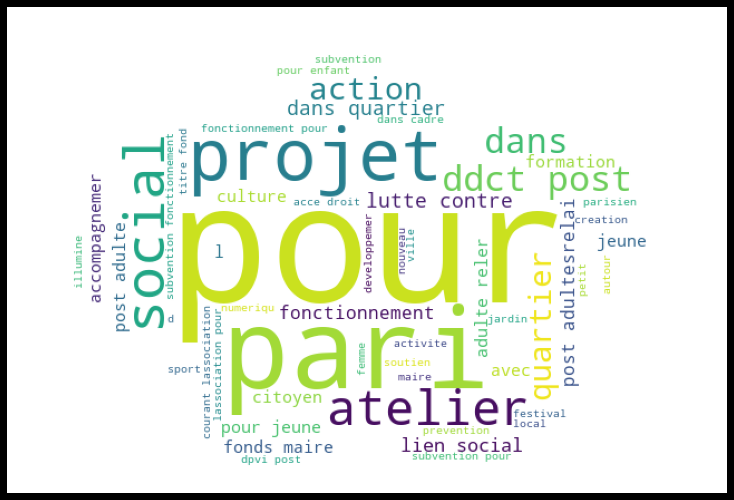

In [104]:
from PIL import Image

data_nlp = pd.read_feather('../00_DataFiles/05_NLPScoring/ParisSubsidies_NLPPreprocessed.feather')

top_words = ''
worst_words = ''

for val in data_nlp.loc[data_nlp.subsidy_granted == 'yes', 'objet_dossier_nlp']:
    top_words += ''.join(val)+''

for val in data_nlp.loc[data_nlp.subsidy_granted == 'no', 'objet_dossier_nlp']:
    worst_words += ''.join(val)+''

pic = np.array(Image.open('cloud.png'))
wordcloud = WordCloud(width = 500, height = 500,
                background_color ='white', mask = pic,
                min_font_size = 10).generate(top_words)

plt.figure(figsize=(10,10), facecolor='black', edgecolor='blue')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

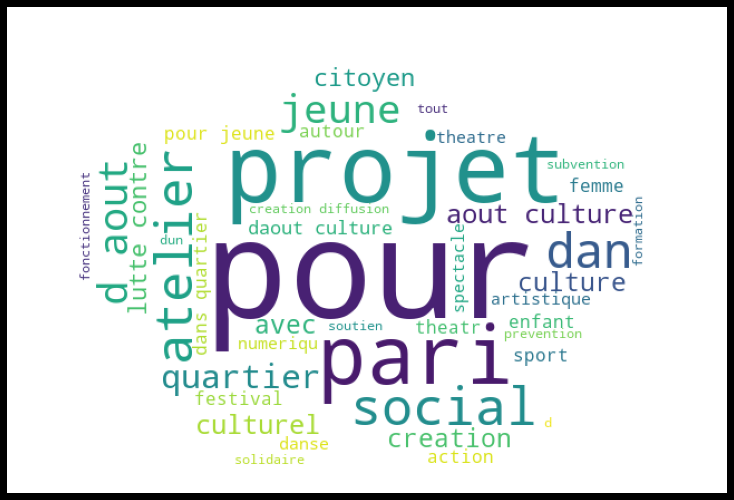

In [105]:
wordcloud = WordCloud(width = 500, height = 500,
                background_color ='white', mask = pic,
                min_font_size = 10).generate(worst_words)

plt.figure(figsize=(10,10), facecolor='black', edgecolor='blue')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()